# Feature Investigation
The aim of this section is to understand the features that have been identified as important for XGBoost classification of the time series problem.

# Set up

In [2]:
!pip install tsfresh

     |████████████████████████████████| 822 kB 47.8 MB/s 
     |████████████████████████████████| 802 kB 21.6 MB/s 
     |████████████████████████████████| 802 kB 45.1 MB/s 
     |████████████████████████████████| 793 kB 48.9 MB/s 
     |████████████████████████████████| 793 kB 39.9 MB/s 
     |████████████████████████████████| 791 kB 58.9 MB/s 
     |████████████████████████████████| 786 kB 56.0 MB/s 
     |████████████████████████████████| 779 kB 53.5 MB/s 
     |████████████████████████████████| 778 kB 51.8 MB/s 
     |████████████████████████████████| 776 kB 46.4 MB/s 
     |████████████████████████████████| 769 kB 36.7 MB/s 
     |████████████████████████████████| 766 kB 48.6 MB/s 
     |████████████████████████████████| 1.0 MB 41.9 MB/s 
     |████████████████████████████████| 722 kB 58.9 MB/s 
     |████████████████████████████████| 722 kB 51.2 MB/s 
     |████████████████████████████████| 715 kB 45.0 MB/s 
     |████████████████████████████████| 705 kB 59.8 MB/s 
     |████████

In [3]:
#link to xfeatures pickle
#https://drive.google.com/file/d/1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9/view?usp=sharing
#download x_features_pick
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9' -O x_features_pick

#get data
!wget https://raw.githubusercontent.com/DanHarJor/CompLabB-UNIPD-TeamDream/main/Daniel/04_XGBoost/DATA/x_ts_L60_Z12_A500_DX50_bias5_N10000.dat
!wget https://raw.githubusercontent.com/DanHarJor/CompLabB-UNIPD-TeamDream/main/Daniel/04_XGBoost/DATA/y_ts_L60_Z12_A500_DX50_bias5_N10000.dat


--2022-04-02 14:08:06--  https://docs.google.com/uc?export=download&id=1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9
Resolving docs.google.com (docs.google.com)... 173.194.195.139, 173.194.195.101, 173.194.195.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.195.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gne2posjc5glscvost3sdne3svdrcl90/1648908450000/02190001126285980519/*/1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9?e=download [following]
--2022-04-02 14:08:08--  https://doc-0g-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gne2posjc5glscvost3sdne3svdrcl90/1648908450000/02190001126285980519/*/1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9?e=download
Resolving doc-0g-6o-docs.googleusercontent.com (doc-0g-6o-docs.googleusercontent.com)... 142.250.152.132, 2607:f8b0:4001:c56::84
Connecting to doc-0g-6o-docs.googleusercontent.com (doc-0g-6o-docs

# Import features as a pickle
The feature extraction took some time. So I saved it as a pickel file that I can load in much faster.

In [1]:
import pickle
#load pickle file
with open('x_features_pick', 'rb') as file:
    x_features = pickle.load(file)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree
import seaborn as sns

In [3]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='x_'+str0
fnamey='y_'+str0
n_class = 3 

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)

#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y[:N_train]
x_val = x_features[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#rescale: in each feature, remove average and divide by std
if True:
    average = np.mean(x_train,axis=0)
    x_train -= average
    x_val -= average

    std = np.std(x_train,axis=0)
    x_train /= std
    x_val /= std

# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = XGBClassifier(**params)

#fit
model.fit(x_train.values,y_train)

N_train= 8000   N_val= 2000   n_class= 3


XGBClassifier(learning_rate=0.3, max_depth=6, objective='multi:softprob',
              use_label_encoder=False)

# Get important features

In [4]:
#get feature names
feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

In [5]:
minval=0.005
print('------------- Feature importance sum = '+str(np.sum(model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])

------------- Feature importance sum = 1.0000001
------------- Showing feature with importance > 0.005
1 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 0.122241266
2 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0 0.12137273
3 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0 0.11570879
4 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 0.09589055
5 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6 0.055770185
6 value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.026710652
7 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0 0.015129274
8 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2 0.012425136
9 value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20) 0.011654274
10 value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.011278342
11 value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.011247869
12 value__change_quantil

value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0
value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0
value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4
value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6


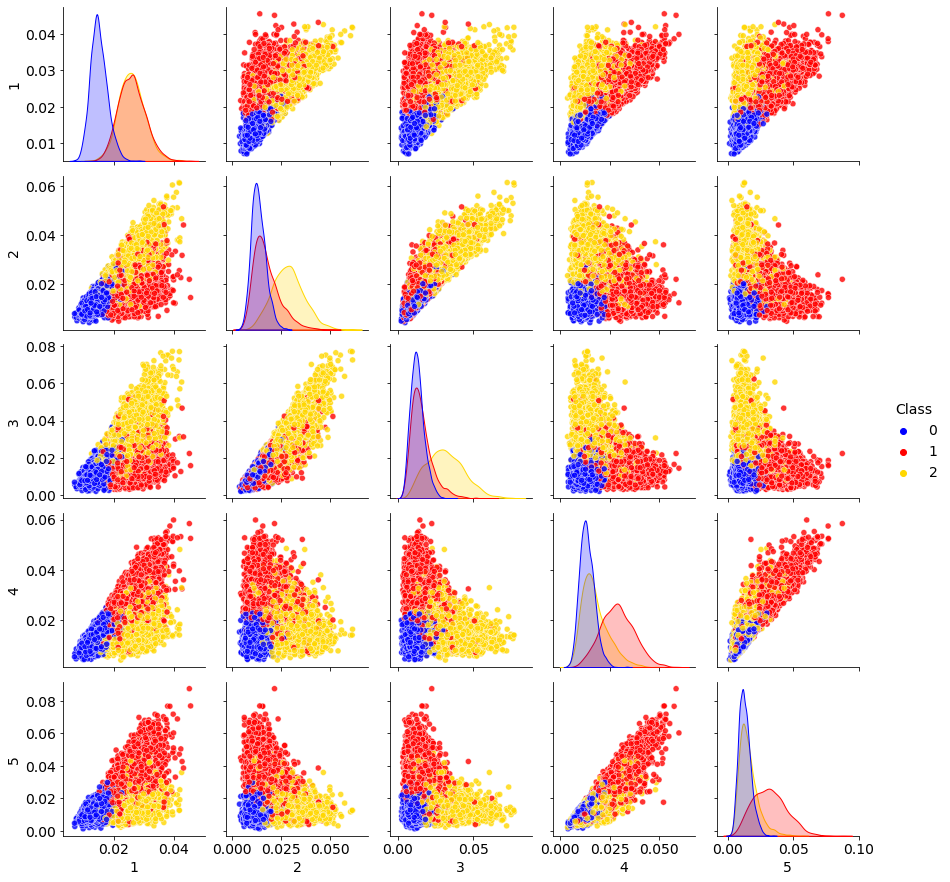

In [6]:
#get feature names given importance order
features = list(feat_imp.keys())

#build dataframe for sns pairplot
df = pd.DataFrame({'1':x_features[features[0]],\
                   '2':x_features[features[1]],\
                   '3':x_features[features[2]],\
                   '4':x_features[features[3]],\
                   '5':x_features[features[4]],\
                   'Class':y})
#pairplot with seaborn
pal = sns.blend_palette(["blue","red","gold"],n_class)
sns.pairplot(df,hue='Class',plot_kws=dict(alpha=0.8),palette=pal);

for i in range(5):
  print(features[i])

# What are these features? 

The 5 most important features are all very similar. The only difference is the ql and qh values which stand for lower quantile and higher quantile.

How are these features extracted from the time series samples?

From looking at the doccumentation I have made my conclusions. Consider 1 sample, which is a time series. The first order differences are calculated. To know what this is please see the example below.  
time  ----------------------1----2----3----4-----5  
values -------------------1----3----4----7----10   
first order   -----------------2----1----3----3  
second order ---------------1----2----0   

Some of these first order differences are used and the rest are discarded. They are kept if both the values used to calculate the difference are in the corridore. The corridore is a subset of the sample between the quantiles. To find the corridore first the sample is ordered. The position of each value in the order is called the rank. The lower and higher quantiles ql and qh are fractions. They are fractions of the rank that decide the bounds of the corridore. This is more easily understood by looking at the example below. Where the red dots show the quantile fraction of the rank and the green line is the data that represents the corridore. If the sample values used to calculate the difference reside in this corridore then the difference is used for the rest of the calculation. The variance of the surviving differences is calculated. This variance is the sample's feature value. This is what is fed into xgboost to represent the sample.

All of the 5 most important features are calculated in this way but with different quantiles.

### Plot Below
The plot below uses a real sample with dummy quartiles. It is mostly to illustrate the concept of the feature.

The blue line is the origional sample. The orange line is the sample ordered. The green section is the corridore. The solid green markers on the blue line represent the points of the origional sample that are within the corridore. Any first order difference calculated with two of the green points are kept for the variance calcualtion. 

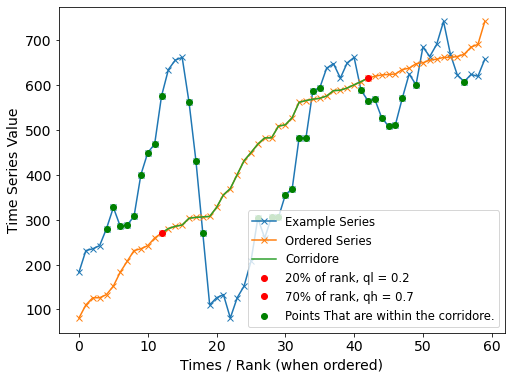

In [7]:
ql = 0.2
qh = 0.7
T = len(x[1])
sorted = np.sort(x[1])
figureCorridore = plt.figure(figsize = (8,6))
plt.plot(range(T),x[1],'x-', label = 'Example Series')
plt.plot(range(T), sorted,'x-', label = 'Ordered Series')
plt.plot(range(int(ql*T),int(qh*T)+1),sorted[int(ql*T):int(qh*T)+1], label = 'Corridore')
plt.plot(int(ql*T),sorted[int(ql*T)],'ro', label = '20% of rank, ql = 0.2',zorder = 20)
plt.plot(int(qh*T),sorted[int(qh*T)],'ro', label = '70% of rank, qh = 0.7',zorder = 20)
plt.xlabel('Times / Rank (when ordered)')
plt.ylabel('Time Series Value')

bin_cat = pd.qcut(x[1], [ql, qh], labels=False)
mask = bin_cat == 0
timesKept = np.arange(len(x[1]))[mask]

plt.scatter(timesKept,x[1][mask],color = 'g', label = 'Points That are within the corridore.',zorder = 5)
plt.legend(fontsize  ='small')
#plt.plot(np.sort(x[1][mask]))

# Why is this feature useful?

The 5 most important features use the quantile ranges  

qh --- ql  
1.0  -- 0  
0.4 -- 0  
1.0 -- 0.4  
1.0 -- 0.6  

The first one from 1 to 0 means the entire sample is used. The others could have issues because the signals are randomly placed in the samples. This means that the points of the sample that represent the signal might be completly ignored if they by chance dont fall within the corridore. 

Using the fist order difference will flatten any gradual change in the values whilst any steep change will have a big peak. When you look at the plot below you can see that the values of the origional sample gradually move up to the hight of the injected sine peak. This means a high value does not constitute a signal. When the first order difference are plotted the peak of the signal rises above the rest of the samples. Thus a signal is distinguishable simply because there is a value much higher than the others. The samples with a signal will have this dominating peak in the first order difference and thus the variance will be high. The variance will be higher for every sample with a signal and lower for every sample with out a signal. This make the samples easy to distinguish.

I am not sure how this would help distinguish between a positive or negative sine signal. As the variance would have a similar magnitude and can only be positive. I am not sure how changing the quartiles could help either.

3350.405630565929


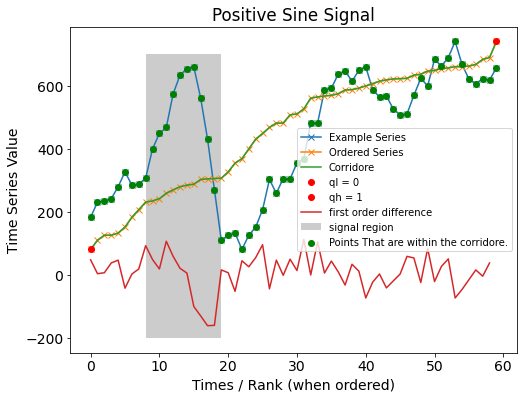

In [31]:
ql = 0
qh = 1
sample = 1
T = len(x[sample])
sorted = np.sort(x[sample])
figureCorridore = plt.figure(figsize = (8,6))
plt.title('Positive Sine Signal')
plt.plot(range(T),x[sample],'x-', label = 'Example Series')
plt.plot(range(T), sorted,'x-', label = 'Ordered Series')
plt.plot(range(T),sorted, label = 'Corridore')
plt.plot(0,sorted[0],'ro', label = 'ql = 0',zorder = 20)
plt.plot(T-1,sorted[T-1],'ro', label = 'qh = 1',zorder = 20)
start = 8
plt.fill_between(range(start,start+12),700,-200, facecolor='gray', alpha=0.4,label = 'signal region')
plt.xlabel('Times / Rank (when ordered)')
plt.ylabel('Time Series Value')

bin_cat = pd.qcut(x[sample], [ql, qh], labels=False)
mask = bin_cat == 0
timesKept = np.arange(len(x[sample]))[mask]

plt.scatter(timesKept,x[sample][mask],color = 'g', label = 'Points That are within the corridore.',zorder = 5)
div = np.diff(x[sample])
plt.plot(div, label = 'first order difference')

plt.legend(loc = 5,prop = {'size' : '10'})



print(np.var(div))
#plt.plot(np.sort(x[1][mask]))

2937.6340132145942


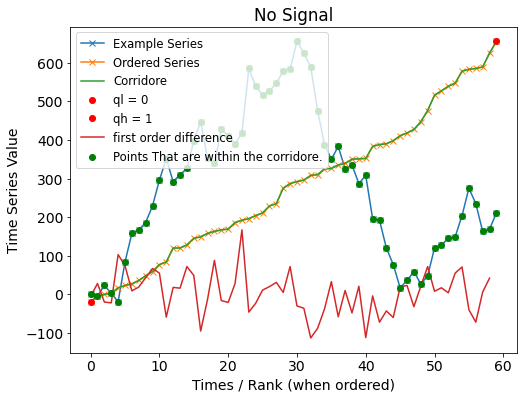

In [57]:
ql = 0
qh = 1
sample = 0
T = len(x[sample])
sorted = np.sort(x[sample])
figureCorridore = plt.figure(figsize = (8,6))
plt.title('No Signal')
plt.plot(range(T),x[sample],'x-', label = 'Example Series')
plt.plot(range(T), sorted,'x-', label = 'Ordered Series')
plt.plot(range(T),sorted, label = 'Corridore')
plt.plot(0,sorted[0],'ro', label = 'ql = 0',zorder = 20)
plt.plot(T-1,sorted[T-1],'ro', label = 'qh = 1',zorder = 20)
plt.xlabel('Times / Rank (when ordered)')
plt.ylabel('Time Series Value')

bin_cat = pd.qcut(x[sample], [ql, qh], labels=False)
mask = bin_cat == 0
timesKept = np.arange(len(x[sample]))[mask]

plt.scatter(timesKept,x[sample][mask],color = 'g', label = 'Points That are within the corridore.',zorder = 5)
div = np.diff(x[sample])
plt.plot(div, label = 'first order difference')

plt.legend(fontsize  ='small')



print(np.var(div))
#plt.plot(np.sort(x[1][mask]))

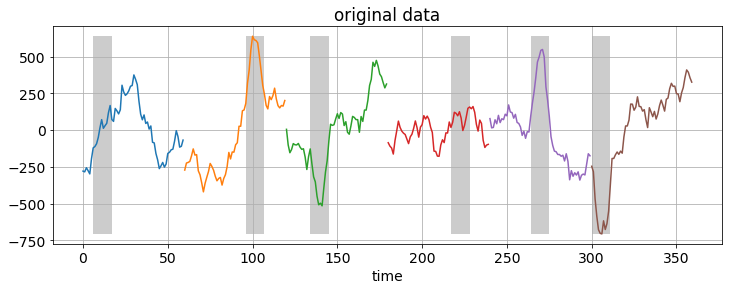

# Understanding the Sea Born Plot

First lets consider the non diagonal plots. There is a plot for every combination of features. The axis show the possible range od values each sample can have for a feature. The axis are shared amongst all of the plots. Each point represents a sample. The color represents which category the samples belong to. Plots whose positions mirror on the main diagonal are the same plot with the axis exchanges. It is clear to see that the features cause the samples to cluster into their distinct categories. This allows them to be distinguised from eachother. 

### Kernal Density Estimations
The diagonal plots are kernal density estimations. They are estimates of the probability density function of the data. A different kernal density plot is made for each category. A histogram of discrete bins would show similar infomation but the kernal density estimation aims to be continous. 

In particular they are *layered* kernal density estimations. This means they aim to show the distributions of all of the plots in that columb combined. 

The first columb shows feature 1 on the x axis and all the other features on the y axis. The kernal density estimation for this columb can only show the spread along the x axis. This shows that the red category and the yellow catefory are on top of eachother. Thus feature 1 is not sufficient to distinguish beteen the red and yellow categories. Although when it is combined with any of the other features there the red and yellow categories spread long this feature axis. This can be seen by looking at the other plots in the columb. 

If only choosing two features to use the best combination would be one where the clusters are seperated as much as possible, feature 2 and 3 are a bad combination whilst 4 and 2 could be a good combination.

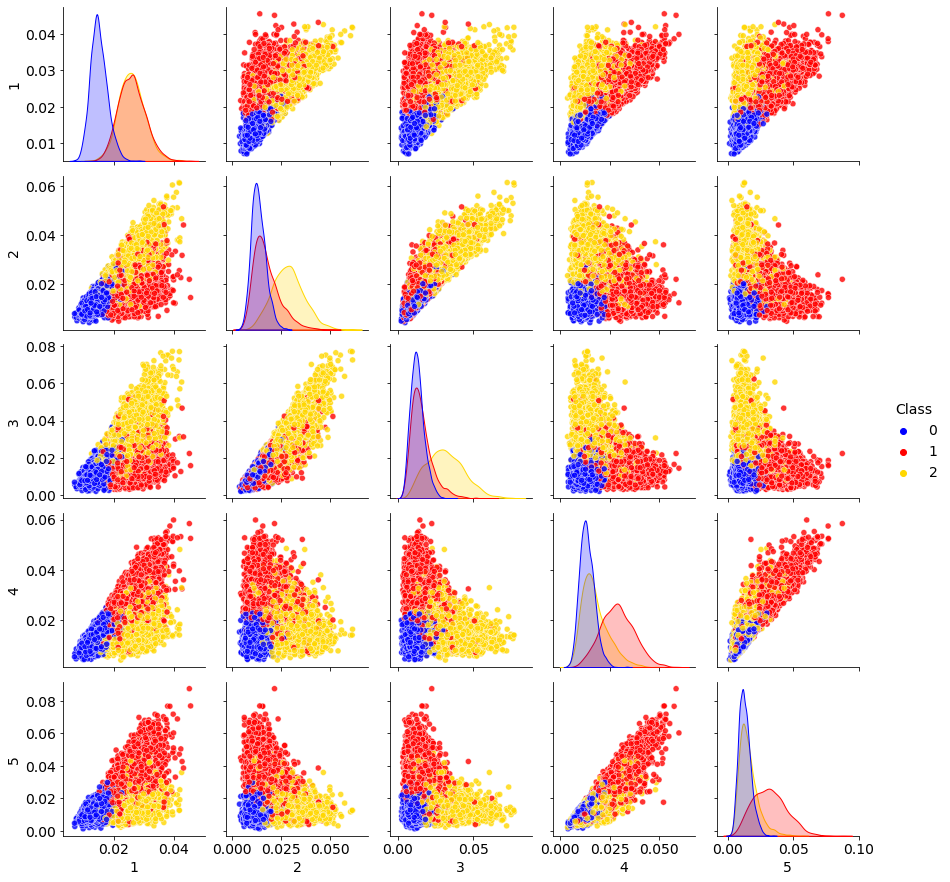

In [9]:
sns.pairplot(df,hue='Class',plot_kws=dict(alpha=0.8),palette=pal);